In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 20

## Validation
# :validation_df - DataFrame to make validation # type: pandas DataFrame
# :preds_df - DataFrame with predictions        # type: pandas DataFrame (columns ['id','prediction'])
# :verbose - print or not full report           # type: bool
def local_validation(validation_df, preds_df, verbose=False):
    validation_df = validation_df.merge(preds_df[['id', 'prediction']], on=['id'], how='left').dropna()
       
    for col in ['target'] + identity_columns:
        validation_df[col] = np.where(validation_df[col] >= 0.5, True, False)

    SUBGROUP_AUC = 'subgroup_auc'
    BPSN_AUC = 'bpsn_auc'  
    BNSP_AUC = 'bnsp_auc'  
    TOXICITY_COLUMN = 'target'

    def compute_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan
    
    def compute_subgroup_auc(df, subgroup, label, model_name):
        return compute_auc(df[df[subgroup]][label], df[df[subgroup]][model_name])
    
    def compute_bpsn_auc(df, subgroup, label, model_name):
        """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
        subgroup_negative_examples = df[df[subgroup] & ~df[label]]
        non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
        examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
        return compute_auc(examples[label], examples[model_name])
    
    def compute_bnsp_auc(df, subgroup, label, model_name):
        """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
        subgroup_positive_examples = df[df[subgroup] & df[label]]
        non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
        examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
        return compute_auc(examples[label], examples[model_name])
    
    def compute_bias_metrics_for_model(dataset, subgroups, model, label_col, include_asegs=False):
        """Computes per-subgroup metrics for all subgroups and one model."""
        records = []
        for subgroup in subgroups:
            record = {
                'subgroup': subgroup,
                'subgroup_size': len(dataset[dataset[subgroup]])
            }
            record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
            record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
            record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
            records.append(record)
        return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
    
    def calculate_overall_auc(df, model_name):
        return metrics.roc_auc_score(df[TOXICITY_COLUMN], df[model_name])
    
    def power_mean(series, p):
        return np.power(sum(np.power(series, p)) / len(series), 1 / p)
    
    def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
        bias_score = np.average([
            power_mean(bias_df[SUBGROUP_AUC], POWER),
            power_mean(bias_df[BPSN_AUC], POWER),
            power_mean(bias_df[BNSP_AUC], POWER)
        ])
        return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

    bias_metrics_df = compute_bias_metrics_for_model(validation_df, identity_columns, 'prediction', 'target')
    if verbose:
        print(bias_metrics_df)
    print(get_final_metric(bias_metrics_df, calculate_overall_auc(validation_df, 'prediction')))

def validate_df(df, preds, verbose=True, val_df='train'):
    df = df.copy()
    df['prediction'] = preds
    if val_df=='train':
        local_validation(train, df, verbose)  
    else:
        local_validation(test, df, verbose)  
## ----------------------------------------------------------------------------------------------------


# Kernel Summary

We can divide this competition pipeline into **5 parts**.

### 1 - Data Augmentation
The main question - can we find a good, labeled dataset to augment our data?
The only one that I have in mind is the past Jigsaw competition.
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Other possibilities:
* Translations
* Sentence permutation

We didn't try anything of this till now.


### 2 - Text preprocessing
**Key findings here:**
* We have to do different preprocess for Bert and for embeddings;
* We can use different preprocess functions (that brings diversity for final stacking);
* We can't use data from the test set, as it will be different for 2nd stage and we can't risk;
* It is a VERY important step.


### 3 - Modeling
**Key findings here:**
* Bert is better than LSTM, but takes much more time;
* Stacking works better with different models (Bert/LSTM/CuDNNGRU);
* Till now we tested 3 models Fatsai Bert / Fastai LSTM / Keras CuDNNGRU;
* More options here - Character Level CNNs in Keras / Elmo / ULMfit;
* Bag of words doesn't perform well even on stacking level;
* We do NOT have much time left to do experiments, so probably we have to concentrate our efforts on what we have done.


### 4 - Stacking
**Key findings here:**
* LGBM works best on this level;
* No overfiting (we have base "regularization" by converting float32 to float16 ))));
* We can add more models here - Log/Linear regression / Catboost / XGBM etc.;
* We can pretrain models and use kernel just for predictions.


### 5 - Ensemble
**Key findings here:**
* If we will use more than 1 model in "part 4" we can do ensembling;
* SDG works best for "weighted" result;
* We need really good additional models in "part 4" to this step makes sense.


### Summary
Our final submission is as strong as strong each part. 
Better preprocess -> better model performance -> better stacking -> better result.
We should do updates and improvements in each step.

Let's see what we have and what we can do step by step.

----------------

# Part 1 - Data Augmentation
#### !IMPORTANT -> All augmentated data should be placed in the same fold with original to control leakage.


## 1.1 Data augmentation from past challenge
What we have from past Jigsaw challenge.

We have "matching" on these labels (name could differ, but the meaning is the same):
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

In [2]:
df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
print('Total labeled Items:', len(df))
print('Lables and Data', list(df))
print('#'*10, 'Number of items by label')
for col in list(df)[2:]:
    print('#'*5,col, len(df[df[col]>=0.5]))

Total labeled Items: 159571
Lables and Data ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
########## Number of items by label
##### toxic 15294
##### severe_toxic 1595
##### obscene 8449
##### threat 478
##### insult 7877
##### identity_hate 1405


Not much data, but it is well labeled. 
What we can do with this set -> preprocess with one of our Preprocessors and train Bert on it.
Predict all our TRAIN and TEST sets and use it as meta-features for stacking.
* No weighting, as we do not have identity labels here
* No need to hard tune Bert for it

We need prof-of-concept check (just simple draft to see if we can have any boost)

## 1.2 Translation
We can use some API to translate PART of the train data set.
Only comment with positive identity matching.

It could give us vocabulary diversity for 2nd stage test data.

**Example**
* Where does the demand for self driving cars come from?  Do we really have a shortage of drivers? **Is this not an industry in search of a market that does not exist?**
* ¿De dónde viene la demanda de autos de auto conducción? ¿Realmente tenemos una escasez de conductores? ¿No es esto una industria en busca de un mercado que no existe?
* Where does the demand for auto driving cars come from? Do we really have a shortage of drivers? **Is not this an industry looking for a market that does not exist?**

We will NOT translate TEST comments as we will not have such option (no online access) for the 2nd stage.

Google cloud and Microsoft have trial API -> We need to test it.


Vocabulary deversity:
~~~~
gay /ɡeɪ/
noun
a homosexual, especially a man.
synonyms:	homosexual, lesbian, gay person, lesbigay;
~~~~

In [3]:
df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv').fillna(0)
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
                    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

df = df[df[identity_columns].sum(axis=1)>0]
print('Comment for translation:', len(df))

Comment for translation: 210192


## 1.3 Sentence permutation
Idea is very simple. 1 + 2 = 3 = 2 + 1

**Example**
* Where does the demand for self driving cars come from?  Do we really have a shortage of drivers? Is this not an industry in search of a market that does not exist?
* Is this not an industry in search of a market that does not exist? Where does the demand for self driving cars come from?  Do we really have a shortage of drivers?

We could try to devide comments by sentences and then do a swap.

In this case we can do it on TRAIN and TEST data (just don't forget to average final score).

As we have huge number of comments we can do it only for train comments with positive identity matching and all test set.


### 1.4 Synonymization
It is a bad option. The main problem here that we can swap words out of context.
To do it in the right way will be a time-consuming task.

## 1.5 Summary
I do not think we have any other real option for data augmentation.

Please correct me if I'm wrong.

** literature **

* classification techniques for noisy and imbalanced data
https://fau.digital.flvc.org/islandora/object/fau%3A4271/datastream/OBJ/download/Classification_techniques_for_noisy_and_imbalanced_data.pdf

* Imbalanced text classification: A term weighting approach
https://ccc.inaoep.mx/~villasen/bib/Imbalanced%20text%20classification-%20A%20term%20weighting%20approach.pdf

* Addressing the problem of Unbalanced Data sets in Sentiment Analysis
https://www.academia.edu/5505329/Addressing_the_problem_of_Unbalanced_Data_sets_in_Sentiment_Analysis

* Handling of Imbalanced Data in Text. Classification: Category-Based Term Weights
https://link.springer.com/chapter/10.1007%2F978-1-84628-754-1_10


----------------------------------------------------------------------------------------------------------------

# Part 2 - Text preprocessing

Actually, we have 4 options for preprocessing. You can find it in our shared kernel.

https://www.kaggle.com/kyakovlev/jigsaw-preprocess-collections

* "Classic preprocess"
https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution

* "Modified classic"
https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part2-usage

* Own preprocess for Bert ("Experimental preprocess for Bert")

* Own preprocess for embeddings ("Experimental preprocess")


"Modified classic" we can use for benchmarks as it serves for bert and for embeddings (I will prepare a "single step" model for a benchmark with the possibility to "probe" LB).

## 2.1 Noise reduction

Main things we can do is to reduce noise in data.

**Links - Isolate domain name / split by words and wrap link string**
* **Example:**
* https://www.theguardian.com/uk-news/2017/jul/26/charlie-gard-us-pro-life-rightwing-ethics"
* theguardian.com [ uk news charlie gard us pro life rightwing ethics ]


**Spam chars - chars are not present in our Vocabulary (Fastext or Glove)**
* "\u200b\u200eعدويهصقأناخلىبمغر" etc.


**Contractions**
* Some Vocabularies have vectors for contractions, some not. Use contraction dict matching to convert missing ones.


**Word normalization**
* Mother's -> Mother
* Mothers -> Mother (if plural form is not in Vocabulary)
* «Mother» - > " Mother "
* etc.


**Punctuation isolation**
* "Mother" -> " Mother "
* Mother.Father -> Mother . Father


**Emoji**
* Depends on Vocabulary 
* Convert to text
* or remove


**Bad words matching**
* @$$ -> ass
* F*ck -> Fuck
* etc

All normalization has to be done to match Vocabulary of the model (FastText/Glove/Bert)


-----

# EDA
Before we can pass to modeling, let's check what kind of data we have.

In [4]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv').fillna(0)
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv').fillna(0)

## Training and test data

In [5]:
print('Columns in TRAIN data set', list(train))
print('Columns in TEST data set', list(test))

Columns in TRAIN data set ['id', 'target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count']
Columns in TEST data set ['id', 'comment_text']


What we can see here is we can use only 'comment_text' directly for training.

Other columns we can use in 'indirect' mode (weights, aux-output, etc.)

## Aux-output
Lets check what kind of columns we can use as aux-output (make predictions and use it on stacking level).

In [6]:
set_1 = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
set_2 = ['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 
        'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 
         'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 
         'other_disability', 'other_gender', 'other_race_or_ethnicity', 
         'other_religion', 'other_sexual_orientation', 'physical_disability', 
         'psychiatric_or_mental_illness', 'transgender', 'white']
set_3 = ['created_date', 'publication_id', 'parent_id', 'article_id','rating']
set_4 = ['funny', 'wow', 'sad', 'likes', 'disagree']

from sklearn.linear_model import LinearRegression
X = train[set_1]
y = np.where((train['target']>=0.5),1,0)

lr = LinearRegression().fit(X, y)
print('LR overall AUC for set_1:', metrics.roc_auc_score(y, lr.predict(X)))
validate_df(train, lr.predict(X), verbose=True, val_df='train')

LR overall AUC for set_1: 0.9952269312413816
   bnsp_auc  bpsn_auc             subgroup  subgroup_auc  subgroup_size
2  0.987218  0.983876  homosexual_gay_o...      0.956842          10997
6  0.988908  0.981660                black      0.957268          14901
7  0.989530  0.982687                white      0.960676          25082
5  0.987721  0.986865               muslim      0.965599          21006
4  0.988489  0.988288               jewish      0.972615           7651
0  0.992212  0.990282                 male      0.983793          44484
1  0.992523  0.990501               female      0.984783          53429
3  0.990592  0.992357            christian      0.984793          40423
8  0.997676  0.986785  psychiatric_or_m...      0.993017           4889
0.9863711832271177


**How we can interpret these results?**
	
IF we can do a perfect prediction for aux-columns in SET 1
we can have  0.9863711832271177 BIASed AUC

It means that this columns ARE important.


### Identities

In [7]:
X = train[set_2]
y = np.where((train['target']>=0.5),1,0)

lr = LinearRegression().fit(X, y)
print('LR overall AUC for set_1:', metrics.roc_auc_score(y, lr.predict(X)))
validate_df(train, lr.predict(X), verbose=True, val_df='train')

LR overall AUC for set_1: 0.5664551637513515
   bnsp_auc  bpsn_auc             subgroup  subgroup_auc  subgroup_size
8  0.983299  0.081282  psychiatric_or_m...      0.535337           4889
6  0.995805  0.025687                black      0.561528          14901
7  0.994440  0.031884                white      0.565319          25082
5  0.986521  0.072573               muslim      0.587189          21006
1  0.971918  0.120669               female      0.588977          53429
2  0.993460  0.039735  homosexual_gay_o...      0.599578          10997
0  0.970874  0.121341                 male      0.628304          44484
3  0.567196  0.703854            christian      0.638012          40423
4  0.957901  0.165183               jewish      0.661186           7651
0.5005886979248844


**How we can interpret these results?**
	
Identity mark -> not always a toxicity. 

Key word here -> NOT ALWAYS, please see that for SOME identity groups subgroup_auc is high.
It means that for some groups identity keywords are toxic ones.

Probably it is good idea to include it in aux output for some model.

## Emotions

In [8]:
X = train[set_4]
y = np.where((train['target']>=0.5),1,0)

lr = LinearRegression().fit(X, y)
print('LR overall AUC for set_1:', metrics.roc_auc_score(y, lr.predict(X)))
validate_df(train, lr.predict(X), verbose=True, val_df='train')

LR overall AUC for set_1: 0.4998526709838365
   bnsp_auc  bpsn_auc             subgroup  subgroup_auc  subgroup_size
5  0.528619  0.440191               muslim      0.469677          21006
2  0.504689  0.475326  homosexual_gay_o...      0.479944          10997
6  0.499472  0.482804                black      0.482026          14901
7  0.512209  0.469666                white      0.482546          25082
1  0.519142  0.464238               female      0.482971          53429
8  0.500665  0.487011  psychiatric_or_m...      0.487590           4889
4  0.524716  0.466572               jewish      0.492091           7651
0  0.513705  0.482875                 male      0.496808          44484
3  0.521030  0.484028            christian      0.505610          40423
0.4925696880689195


NOTHING)).
How we can use this information?

['funny', 'wow', 'sad', 'likes', 'disagree']

It is very valuable information -> we just need to find a way to use it.





## Information about comment and article




In [9]:
train['created_date'] = pd.to_datetime(train['created_date'])
train['year'] = train['created_date'].dt.year.astype(np.int8)
train['month'] = train['created_date'].dt.month.astype(np.int8)
train['day'] = train['created_date'].dt.day.astype(np.int8)
train['weekday'] = train['created_date'].dt.weekday.astype(np.int8)
train['time_block'] = (train['created_date'].dt.year - 2015).astype(np.int8)*12 + (train['created_date'].dt.month).astype(np.int8)

set_3 = ['year', 'month', 'day', 'weekday', 'publication_id', 'parent_id', 'article_id']

X = train[set_3]
y = np.where((train['target']>=0.5),1,0)

lr = LinearRegression().fit(X, y)
print('LR overall AUC for set_1:', metrics.roc_auc_score(y, lr.predict(X)))
validate_df(train, lr.predict(X), verbose=True, val_df='train')

LR overall AUC for set_1: 0.5284591347749571
   bnsp_auc  bpsn_auc             subgroup  subgroup_auc  subgroup_size
3  0.509863  0.527962            christian      0.508128          40423
2  0.493212  0.546381  homosexual_gay_o...      0.510557          10997
7  0.532223  0.508260                white      0.512118          25082
8  0.492354  0.549569  psychiatric_or_m...      0.512743           4889
4  0.532602  0.515800               jewish      0.519907           7651
5  0.531736  0.516659               muslim      0.520126          21006
0  0.534100  0.515633                 male      0.521159          44484
1  0.540468  0.510690               female      0.522641          53429
6  0.543130  0.511257                black      0.526597          14901
0.5219712966032188


It seems that this data is useless,  but it's not. It is some kind of Categorical data and we need to treat it in that way.

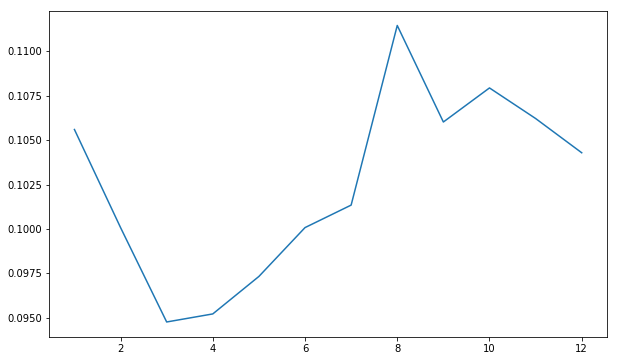

In [10]:
temp_df = train.groupby('month').agg({'target':'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(temp_df['month'], temp_df['target']);

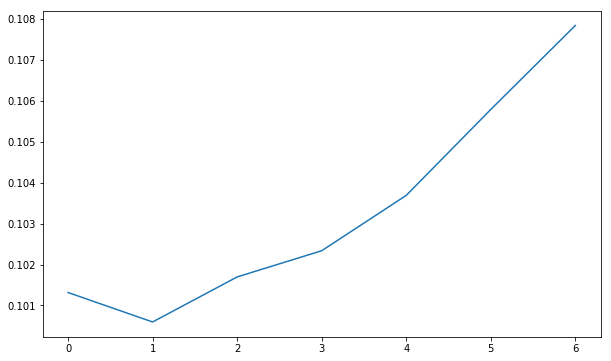

In [11]:
temp_df = train.groupby('weekday').agg({'target':'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(temp_df['weekday'], temp_df['target']);

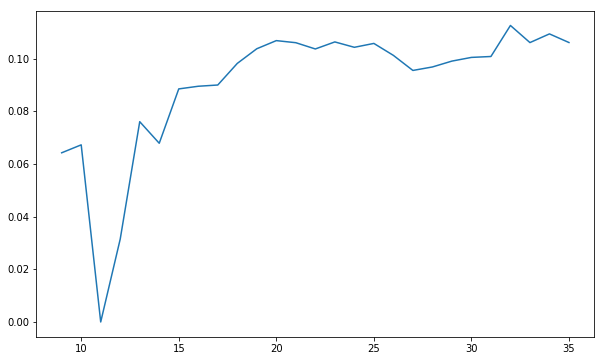

In [12]:
temp_df = train.groupby('time_block').agg({'target':'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(temp_df['time_block'], temp_df['target']);

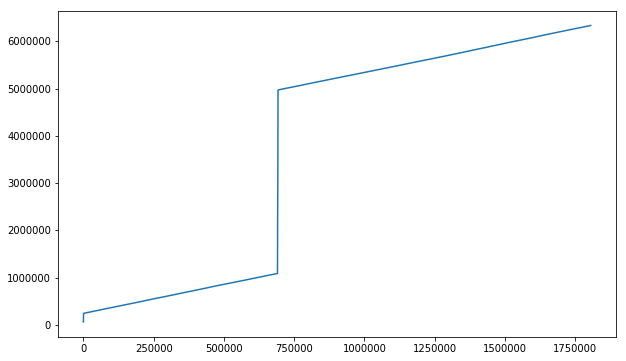

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train['id']);